# **This cell uses the google.colab.files module to create an interactive upload widget in your Colab environment.**

In [ ]:
# Cell 1: Upload Data Files
from google.colab import files
import io

print("📤 UPLOADING DATA FILES")
print("="*60)
print("Please upload your 'corpus' and 'test' files")
print("="*60)

uploaded = files.upload()

# List uploaded files
print("\n Files uploaded successfully:")
for filename in uploaded.keys():
    print(f"  - {filename}")

📤 UPLOADING DATA FILES
Please upload your 'corpus' and 'test' files


Saving corpus.txt to corpus.txt
Saving test.txt to test.txt

 Files uploaded successfully:
  - corpus.txt
  - test.txt


Install all dependencies and verify files

In [ ]:
# Cell 2: Install Dependencies
print("📦 Installing required packages...")

# Most packages are pre-installed in Colab, but let's ensure we have everything
!pip install -q numpy matplotlib

print("✅ All packages installed!")


📦 Installing required packages...
✅ All packages installed!


In [ ]:
# Cell 3: Verify Files
import os

print("📁 Checking uploaded files...")
print("="*60)

# List all files in current directory
files_in_directory = os.listdir('.')
print(f"Files in current directory: {files_in_directory}")

# Check if corpus and test files exist
if 'corpus' in files_in_directory or 'corpus.txt' in files_in_directory:
    print("✅ Corpus file found!")
else:
    print("❌ Corpus file NOT found. Please upload it.")

if 'test' in files_in_directory or 'test.txt' in files_in_directory:
    print("✅ Test file found!")
else:
    print("❌ Test file NOT found. Please upload it.")

print("="*60)


📁 Checking uploaded files...
Files in current directory: ['.config', 'test.txt', 'corpus.txt', 'sample_data']
✅ Corpus file found!
✅ Test file found!


# **This cell defines the HangmanHMM class, which serves as the statistical model for guessing letters.**
__init__: Initializes a dictionary models_by_length to store a separate statistical model for each word length, and a letter_freq Counter for fallback predictions.

train: Populates models_by_length. It iterates through the corpus and groups words by length.

_train_length_model: This is the core of the HMM. For a given set of words of the same length, it calculates:

    Positional Letter Counts (position_letter_counts): A list of Counters. This models the probability of a letter appearing at a specific position (e.g., 'e' is common at the end of a 4-letter word). This is analogous to an HMM's emission probability.

    Letter Transitions (letter_transitions): A dictionary of Counters. This models the probability of one letter following another (e.g., 'h' is often followed by 'e'). This is analogous to an HMM's transition probability.

predict_letter_probabilities: This is the inference function. Given a masked_word and guessed_letters, it scores unguessed letters by combining:

    Scores from position_letter_counts for all blank (_) positions.

    Scores from letter_transitions for blanks adjacent to already-guessed letters (weighted by 0.5). It then normalizes these scores into a probability distribution.

_fallback_frequency: If no specific model exists, it returns probabilities based on the overall letter frequency in the entire corpus.

save/load: Uses pickle to save and load the trained HMM models.

In [ ]:
# Cell 4: Hidden Markov Model Implementation

import numpy as np
from collections import defaultdict, Counter
import pickle

class HangmanHMM:
    """
    Hidden Markov Model for Hangman letter prediction
    """

    def __init__(self):
        self.models_by_length = {}
        self.letter_freq = Counter()
        self.trained = False

    def train(self, corpus_words):
        """Train HMM on corpus words"""
        print("🔧 Training HMM on corpus...")

        words_by_length = defaultdict(list)
        for word in corpus_words:
            word = word.strip().lower()
            if word.isalpha():
                words_by_length[len(word)].append(word)
                self.letter_freq.update(word)

        for length, words in words_by_length.items():
            self.models_by_length[length] = self._train_length_model(words, length)

        self.trained = True
        print(f"✅ HMM trained on {len(corpus_words)} words across {len(self.models_by_length)} length groups")

    def _train_length_model(self, words, length):
        """Train HMM for specific word length"""
        model = {
            'position_letter_counts': [Counter() for _ in range(length)],
            'letter_transitions': defaultdict(Counter),
            'total_words': len(words)
        }

        for word in words:
            for pos, letter in enumerate(word):
                model['position_letter_counts'][pos][letter] += 1
                if pos > 0:
                    prev_letter = word[pos-1]
                    model['letter_transitions'][prev_letter][letter] += 1

        return model

    def predict_letter_probabilities(self, masked_word, guessed_letters):
        """Predict probability distribution over letters"""
        word_length = len(masked_word)

        if word_length not in self.models_by_length:
            return self._fallback_frequency(guessed_letters)

        model = self.models_by_length[word_length]
        letter_scores = Counter()

        for pos, char in enumerate(masked_word):
            if char == '_':
                pos_counts = model['position_letter_counts'][pos]
                for letter, count in pos_counts.items():
                    if letter not in guessed_letters:
                        letter_scores[letter] += count

        for pos, char in enumerate(masked_word):
            if char != '_' and pos < word_length - 1:
                if masked_word[pos + 1] == '_':
                    transitions = model['letter_transitions'].get(char, {})
                    for letter, count in transitions.items():
                        if letter not in guessed_letters:
                            letter_scores[letter] += count * 0.5

        total = sum(letter_scores.values())
        if total == 0:
            return self._fallback_frequency(guessed_letters)

        probs = {letter: score/total for letter, score in letter_scores.items()}
        return probs

    def _fallback_frequency(self, guessed_letters):
        """Fallback to overall letter frequency"""
        available_letters = set(self.letter_freq.keys()) - guessed_letters
        total = sum(self.letter_freq[l] for l in available_letters)

        if total == 0:
            return {l: 1.0/len(available_letters) for l in available_letters}

        return {letter: self.letter_freq[letter]/total
                for letter in available_letters}

    def save(self, filepath):
        """Save trained model"""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'models_by_length': self.models_by_length,
                'letter_freq': self.letter_freq,
                'trained': self.trained
            }, f)
        print(f"💾 HMM saved to {filepath}")

    def load(self, filepath):
        """Load trained model"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.models_by_length = data['models_by_length']
            self.letter_freq = data['letter_freq']
            self.trained = data['trained']
        print(f"📂 HMM loaded from {filepath}")

print("✅ HangmanHMM class defined!")


✅ HangmanHMM class defined!


# **Purpose: This cell defines the HangmanEnvironment class, which simulates the game of Hangman. It's built like a standard OpenAI Gym environment.**

Action:

    __init__: Sets up the word list and the max_wrong_guesses (6).

    reset: Starts a new game by picking a random word and resetting all game variables (guessed_letters, wrong_guesses, etc.).

    get_state: Returns a dictionary representing the current state of the game (the masked_word, guessed_letters, lives_left, etc.).

    step(action): This is the game engine. It takes a guess_letter as an action and updates the game. It defines the reward structure:

        Repeated Guess: reward = -2

        Correct Guess: reward = 5

        Wrong Guess: reward = -10

        Game Won: reward = 100 (final-step bonus)

        Game Lost: reward = -50 (final-step penalty) It returns the (next_state, reward, done, info) tuple, which is standard for RL environments.

In [ ]:
# Cell 5: Hangman Environment
import random

class HangmanEnvironment:
    """Hangman game environment for RL agent"""

    def __init__(self, word_list, max_wrong_guesses=6):
        self.word_list = [w.strip().lower() for w in word_list if w.strip().isalpha()]
        self.max_wrong_guesses = max_wrong_guesses
        self.reset()

    def reset(self, word=None):
        """Reset environment for new game"""
        if word is None:
            self.target_word = random.choice(self.word_list)
        else:
            self.target_word = word.lower()

        self.word_length = len(self.target_word)
        self.guessed_letters = set()
        self.correct_guesses = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_over = False
        self.won = False

        return self.get_state()

    def get_state(self):
        """Get current game state"""
        masked_word = ''.join([
            letter if letter in self.correct_guesses else '_'
            for letter in self.target_word
        ])

        return {
            'masked_word': masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_left': self.max_wrong_guesses - self.wrong_guesses,
            'word_length': self.word_length,
            'game_over': self.game_over,
            'won': self.won,
            'target_word': self.target_word
        }

    def step(self, guess_letter):
        """Take action (guess a letter)"""
        guess_letter = guess_letter.lower()

        if guess_letter in self.guessed_letters:
            self.repeated_guesses += 1
            reward = -2
            return self.get_state(), reward, self.game_over, {
                'repeated': True,
                'correct': False
            }

        self.guessed_letters.add(guess_letter)

        if guess_letter in self.target_word:
            self.correct_guesses.add(guess_letter)
            reward = 5

            if all(letter in self.correct_guesses for letter in self.target_word):
                self.game_over = True
                self.won = True
                reward = 100
        else:
            self.wrong_guesses += 1
            reward = -10

            if self.wrong_guesses >= self.max_wrong_guesses:
                self.game_over = True
                self.won = False
                reward = -50

        return self.get_state(), reward, self.game_over, {
            'repeated': False,
            'correct': guess_letter in self.target_word
        }

print("✅ HangmanEnvironment class defined!")


✅ HangmanEnvironment class defined!


# **Purpose: This is the core of the project, defining the QLearningAgent that learns to play Hangman.**

Action:

    __init__: Initializes the Q-learning parameters (alpha, gamma, epsilon) and, crucially, takes the hmm_model as an input. The q_table is a defaultdict of defaultdict(float).

    get_state_key: A critical function that converts the dictionary state from the environment into a single, hashable string: f"{masked_word}:{guessed}:{lives}". This string is used as the key in the q_table.

    choose_action: Implements the exploration/exploitation policy.

        Exploitation (else block): Calls _choose_best_action.

        Exploration (if block): This is not a simple random guess. It's HMM-guided exploration. It uses the HMM's predictions to make a probabilistic guess among the available letters, making exploration much more efficient.

    _choose_best_action: This is the agent's hybrid policy. It combines what it has learned (the Q-value) with the HMM's statistical prior (the HMM probability). The action is chosen based on a weighted sum: 0.6 * q_value + 0.4 * hmm_prob * 10.

    update: Implements the standard Q-learning update rule: Q(s,a)←Q(s,a)+α⋅(R+γ⋅maxa′​Q(s′,a′)−Q(s,a))

    train/train_episode: The main training loops that run the agent in the environment for num_episodes, calling choose_action and update at each step and decaying epsilon.

    save/load: Pickles the agent's q_table and training status.

In [ ]:
# Cell 6: Q-Learning Agent
class QLearningAgent:
    """Q-Learning agent for Hangman using HMM probabilities"""

    def __init__(self, hmm_model, learning_rate=0.1, discount_factor=0.95,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.hmm = hmm_model
        self.q_table = defaultdict(lambda: defaultdict(float))

        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.training_stats = {
            'episodes': 0,
            'wins': 0,
            'total_reward': 0,
            'rewards_per_episode': []
        }

    def get_state_key(self, state):
        """Convert state to hashable key for Q-table"""
        masked_word = state['masked_word']
        guessed = ''.join(sorted(state['guessed_letters']))
        lives = state['lives_left']
        return f"{masked_word}:{guessed}:{lives}"

    def choose_action(self, state, training=True):
        """Choose action using epsilon-greedy policy"""
        available_actions = set('abcdefghijklmnopqrstuvwxyz') - state['guessed_letters']

        if not available_actions:
            return random.choice(list('abcdefghijklmnopqrstuvwxyz'))

        if training and random.random() < self.epsilon:
            hmm_probs = self.hmm.predict_letter_probabilities(
                state['masked_word'],
                state['guessed_letters']
            )

            if hmm_probs:
                letters = list(hmm_probs.keys())
                probs = list(hmm_probs.values())
                prob_sum = sum(probs)
                if prob_sum > 0:
                    probs = [p/prob_sum for p in probs]
                    return np.random.choice(letters, p=probs)

            return random.choice(list(available_actions))
        else:
            return self._choose_best_action(state, available_actions)

    def _choose_best_action(self, state, available_actions):
        """Choose best action combining Q-values and HMM probabilities"""
        state_key = self.get_state_key(state)
        hmm_probs = self.hmm.predict_letter_probabilities(
            state['masked_word'],
            state['guessed_letters']
        )

        action_scores = {}
        for action in available_actions:
            q_value = self.q_table[state_key].get(action, 0)
            hmm_prob = hmm_probs.get(action, 0.001)
            action_scores[action] = 0.6 * q_value + 0.4 * hmm_prob * 10

        best_action = max(action_scores, key=action_scores.get)
        return best_action

    def update(self, state, action, reward, next_state, done):
        """Update Q-values using Q-learning update rule"""
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        current_q = self.q_table[state_key][action]

        if done:
            max_next_q = 0
        else:
            available_next_actions = set('abcdefghijklmnopqrstuvwxyz') - next_state['guessed_letters']
            if available_next_actions:
                max_next_q = max([self.q_table[next_state_key].get(a, 0)
                                 for a in available_next_actions])
            else:
                max_next_q = 0

        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state_key][action] = new_q

    def train_episode(self, env):
        """Train agent for one episode"""
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = self.choose_action(state, training=True)
            next_state, reward, done, info = env.step(action)

            self.update(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

        self.training_stats['episodes'] += 1
        if env.won:
            self.training_stats['wins'] += 1
        self.training_stats['total_reward'] += total_reward
        self.training_stats['rewards_per_episode'].append(total_reward)

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return total_reward, env.won

    def train(self, env, num_episodes=5000, verbose_every=500):
        """Train agent for multiple episodes"""
        print(f"\n🏋️ Training Q-Learning agent for {num_episodes} episodes...")

        for episode in range(num_episodes):
            reward, won = self.train_episode(env)

            if (episode + 1) % verbose_every == 0:
                recent_wins = sum(self.training_stats['rewards_per_episode'][-verbose_every:])
                win_rate = self.training_stats['wins'] / self.training_stats['episodes']
                avg_reward = recent_wins / verbose_every
                print(f"Episode {episode + 1}/{num_episodes} | "
                      f"Win Rate: {win_rate:.2%} | "
                      f"Avg Reward: {avg_reward:.2f} | "
                      f"Epsilon: {self.epsilon:.3f}")

        print("\n✅ Training completed!")
        print(f"Final Win Rate: {self.training_stats['wins'] / self.training_stats['episodes']:.2%}")

    def save(self, filepath):
        """Save trained agent"""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'q_table': dict(self.q_table),
                'training_stats': self.training_stats,
                'epsilon': self.epsilon
            }, f)
        print(f"💾 Agent saved to {filepath}")

    def load(self, filepath):
        """Load trained agent"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.q_table = defaultdict(lambda: defaultdict(float), data['q_table'])
            self.training_stats = data['training_stats']
            self.epsilon = data['epsilon']
        print(f"📂 Agent loaded from {filepath}")

print("✅ QLearningAgent class defined!")


✅ QLearningAgent class defined!


# **Defines the HangmanEvaluator to test the trained agent's performance on the unseen test set.**
evaluate: Runs a specified number of games using the test_words. Importantly, it calls self.agent.choose_action(state, training=False), which turns off exploration (epsilon = 0) and relies purely on the exploitation policy.

print_results: Calculates and prints final metrics, including success rate, average wrong guesses, and a final custom score.

In [ ]:
# Cell 7: Evaluator Class
class HangmanEvaluator:
    """Evaluate Hangman agent performance"""

    def __init__(self, agent, env):
        self.agent = agent
        self.env = env

    def evaluate(self, test_words, max_games=2000):
        """Evaluate agent on test set"""
        print(f"\n{'='*60}")
        print(f"📊 EVALUATING AGENT ON {min(len(test_words), max_games)} GAMES")
        print(f"{'='*60}\n")

        results = {
            'games_played': 0,
            'games_won': 0,
            'total_wrong_guesses': 0,
            'total_repeated_guesses': 0,
            'game_details': []
        }

        eval_words = test_words[:max_games]

        for idx, word in enumerate(eval_words):
            state = self.env.reset(word=word)
            done = False
            wrong_guesses = 0
            repeated_guesses = 0

            while not done:
                action = self.agent.choose_action(state, training=False)
                next_state, reward, done, info = self.env.step(action)

                if info['repeated']:
                    repeated_guesses += 1
                if not info['correct'] and not info['repeated']:
                    wrong_guesses += 1

                state = next_state

            results['games_played'] += 1
            if self.env.won:
                results['games_won'] += 1
            results['total_wrong_guesses'] += wrong_guesses
            results['total_repeated_guesses'] += repeated_guesses

            results['game_details'].append({
                'word': word,
                'won': self.env.won,
                'wrong_guesses': wrong_guesses,
                'repeated_guesses': repeated_guesses
            })

            if (idx + 1) % 200 == 0:
                current_win_rate = results['games_won'] / results['games_played']
                print(f"Progress: {idx + 1}/{len(eval_words)} | "
                      f"Win Rate: {current_win_rate:.2%}")

        success_rate = results['games_won'] / results['games_played']
        avg_wrong = results['total_wrong_guesses'] / results['games_played']
        avg_repeated = results['total_repeated_guesses'] / results['games_played']

        final_score = (success_rate * 2000) - \
                     (results['total_wrong_guesses'] * 5) - \
                     (results['total_repeated_guesses'] * 2)

        results['success_rate'] = success_rate
        results['avg_wrong_guesses'] = avg_wrong
        results['avg_repeated_guesses'] = avg_repeated
        results['final_score'] = final_score

        self.print_results(results)

        return results

    def print_results(self, results):
        """Print formatted evaluation results"""
        print(f"\n{'='*60}")
        print(f"📈 EVALUATION RESULTS")
        print(f"{'='*60}")
        print(f"Games Played:          {results['games_played']}")
        print(f"Games Won:             {results['games_won']}")
        print(f"Success Rate:          {results['success_rate']:.2%}")
        print(f"Total Wrong Guesses:   {results['total_wrong_guesses']}")
        print(f"Avg Wrong Guesses:     {results['avg_wrong_guesses']:.2f}")
        print(f"Total Repeated Guesses: {results['total_repeated_guesses']}")
        print(f"Avg Repeated Guesses:  {results['avg_repeated_guesses']:.2f}")
        print(f"{'='*60}")
        print(f"🎯 FINAL SCORE:        {results['final_score']:.2f}")
        print(f"{'='*60}\n")

print("✅ HangmanEvaluator class defined!")


✅ HangmanEvaluator class defined!


# *Purpose: This cell is the main script that ties everything together.*

Action:

    Load Data: Loads corpus_words and test_words.

    Train HMM: Creates a HangmanHMM instance and trains it on the corpus.

    Create Environment: Creates a HangmanEnvironment instance.

    Train RL Agent: Creates the QLearningAgent, providing it with the trained HMM. It then trains the agent for 5000 episodes.

    Save Models: Saves the trained hmm_model.pkl and agent_model.pkl.

In [ ]:
# Cell 8: Main Training Pipeline
import matplotlib.pyplot as plt

def load_data():
    """Load corpus and test words"""
    print("📂 Loading data...")

    # Try both possible filenames
    try:
        with open('corpus', 'r', encoding='utf-8') as f:
            corpus_words = [line.strip().lower() for line in f if line.strip()]
    except:
        with open('corpus.txt', 'r', encoding='utf-8') as f:
            corpus_words = [line.strip().lower() for line in f if line.strip()]

    try:
        with open('test', 'r', encoding='utf-8') as f:
            test_words = [line.strip().lower() for line in f if line.strip()]
    except:
        with open('test.txt', 'r', encoding='utf-8') as f:
            test_words = [line.strip().lower() for line in f if line.strip()]

    print(f"✅ Loaded {len(corpus_words)} corpus words")
    print(f"✅ Loaded {len(test_words)} test words")

    return corpus_words, test_words

# Load data
corpus_words, test_words = load_data()

# Step 1: Train HMM
print(f"\n{'='*60}")
print("STEP 1: TRAINING HIDDEN MARKOV MODEL")
print(f"{'='*60}")
hmm = HangmanHMM()
hmm.train(corpus_words)
hmm.save('hmm_model.pkl')

# Step 2: Create environment
print(f"\n{'='*60}")
print("STEP 2: CREATING HANGMAN ENVIRONMENT")
print(f"{'='*60}")
env = HangmanEnvironment(corpus_words, max_wrong_guesses=6)
print(f"✅ Environment created with {len(corpus_words)} words")

# Step 3: Train RL agent
print(f"\n{'='*60}")
print("STEP 3: TRAINING REINFORCEMENT LEARNING AGENT")
print(f"{'='*60}")
agent = QLearningAgent(
    hmm_model=hmm,
    learning_rate=0.1,
    discount_factor=0.95,
    epsilon=1.0,
    epsilon_decay=0.9995,
    epsilon_min=0.05
)

# Train for 5000 episodes
agent.train(env, num_episodes=5000, verbose_every=500)
agent.save('agent_model.pkl')

print("\n✅ Training pipeline completed!")


📂 Loading data...
✅ Loaded 50000 corpus words
✅ Loaded 2000 test words

STEP 1: TRAINING HIDDEN MARKOV MODEL
🔧 Training HMM on corpus...
✅ HMM trained on 50000 words across 24 length groups
💾 HMM saved to hmm_model.pkl

STEP 2: CREATING HANGMAN ENVIRONMENT
✅ Environment created with 50000 words

STEP 3: TRAINING REINFORCEMENT LEARNING AGENT

🏋️ Training Q-Learning agent for 5000 episodes...
Episode 500/5000 | Win Rate: 10.20% | Avg Reward: -61.06 | Epsilon: 0.779
Episode 1000/5000 | Win Rate: 9.60% | Avg Reward: -61.62 | Epsilon: 0.606
Episode 1500/5000 | Win Rate: 10.87% | Avg Reward: -53.07 | Epsilon: 0.472
Episode 2000/5000 | Win Rate: 12.15% | Avg Reward: -48.29 | Epsilon: 0.368
Episode 2500/5000 | Win Rate: 13.92% | Avg Reward: -39.62 | Epsilon: 0.286
Episode 3000/5000 | Win Rate: 14.63% | Avg Reward: -43.83 | Epsilon: 0.223
Episode 3500/5000 | Win Rate: 15.31% | Avg Reward: -41.32 | Epsilon: 0.174
Episode 4000/5000 | Win Rate: 16.55% | Avg Reward: -31.97 | Epsilon: 0.135
Episode 

# **Cell 9: Plot Training Progress**

    Purpose: To visualize the agent's learning process.

    Action: It plots the rewards_per_episode from the agent's training stats, along with a 100-episode moving average. The resulting graph clearly shows an upward trend in average reward, reinforcing that the agent is improving.

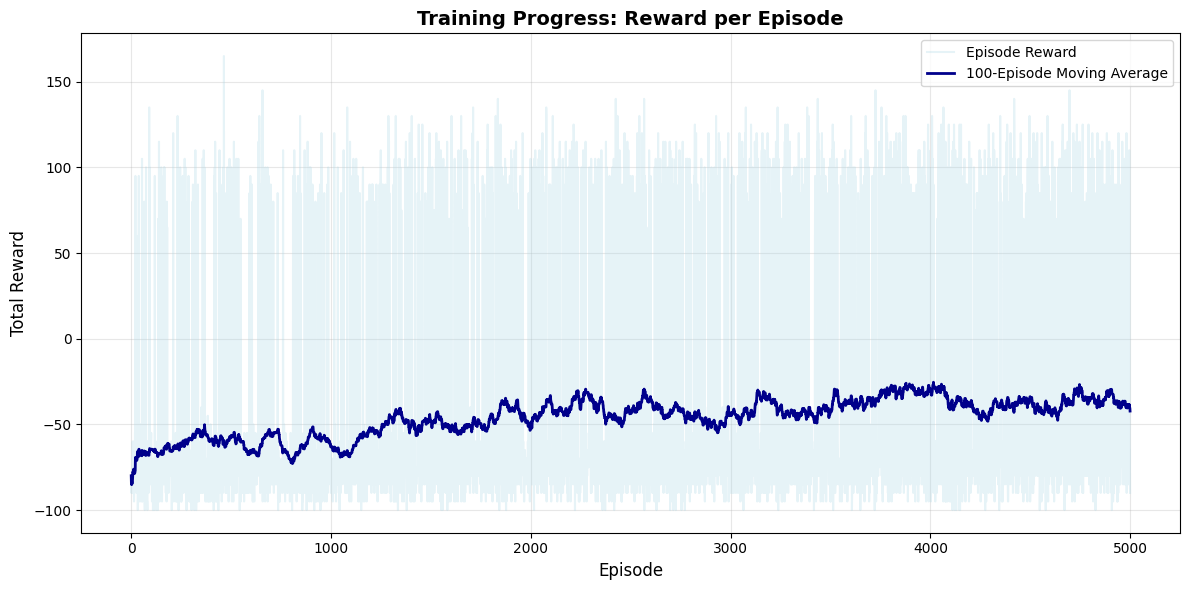

📊 Training visualization complete!


In [ ]:
# Cell 9: Plot Training Progress
def plot_training_progress(agent):
    """Plot training progress"""
    rewards = agent.training_stats['rewards_per_episode']

    window = 100
    moving_avg = []
    for i in range(len(rewards)):
        start = max(0, i - window)
        moving_avg.append(np.mean(rewards[start:i+1]))

    plt.figure(figsize=(12, 6))
    plt.plot(rewards, alpha=0.3, label='Episode Reward', color='lightblue')
    plt.plot(moving_avg, label=f'{window}-Episode Moving Average',
             linewidth=2, color='darkblue')
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Total Reward', fontsize=12)
    plt.title('Training Progress: Reward per Episode', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("📊 Training visualization complete!")

# Plot training progress
plot_training_progress(agent)


# **Cell 10: Evaluation on Test Set**

    Purpose: To formally evaluate the trained agent's final performance.

    Action: It uses the HangmanEvaluator class to run the agent against the 2000 words in the test.txt file.

    Output: The agent achieves a 25.40% success rate with an average of 5.45 wrong guesses per game. It makes 0 repeated guesses, showing it successfully learned from the -2 reward penalty.

In [ ]:
# Cell 10: Evaluation on Test Set
print(f"\n{'='*60}")
print("STEP 4: EVALUATION ON TEST SET")
print(f"{'='*60}")

test_env = HangmanEnvironment(test_words, max_wrong_guesses=6)
evaluator = HangmanEvaluator(agent, test_env)
results = evaluator.evaluate(test_words, max_games=2000)

# Save results
import json
with open('evaluation_results.json', 'w') as f:
    results_summary = {k: v for k, v in results.items() if k != 'game_details'}
    json.dump(results_summary, f, indent=2)
print("💾 Results saved to evaluation_results.json")



STEP 4: EVALUATION ON TEST SET

📊 EVALUATING AGENT ON 2000 GAMES

Progress: 200/2000 | Win Rate: 23.00%
Progress: 400/2000 | Win Rate: 27.00%
Progress: 600/2000 | Win Rate: 26.50%
Progress: 800/2000 | Win Rate: 26.38%
Progress: 1000/2000 | Win Rate: 26.40%
Progress: 1200/2000 | Win Rate: 26.00%
Progress: 1400/2000 | Win Rate: 26.00%
Progress: 1600/2000 | Win Rate: 25.12%
Progress: 1800/2000 | Win Rate: 24.78%
Progress: 2000/2000 | Win Rate: 25.40%

📈 EVALUATION RESULTS
Games Played:          2000
Games Won:             508
Success Rate:          25.40%
Total Wrong Guesses:   10890
Avg Wrong Guesses:     5.45
Total Repeated Guesses: 0
Avg Repeated Guesses:  0.00
🎯 FINAL SCORE:        -53942.00

💾 Results saved to evaluation_results.json


# **Cell 10a: Plot Win Rate by Word Length**

    Purpose: A diagnostic cell to analyze the agent's performance in more detail.

    Action: It loads the game_details from the evaluation results into a pandas DataFrame. It then groups the games by word_length and calculates the mean win rate for each length, plotting the result as a bar chart. This helps identify if the HMM/agent is stronger or weaker on words of a particular length.

# **Cell 11: Download Trained Models and Results**

    Purpose: To save the final project artifacts.

    Action: It uses google.colab.files.download to download the two trained models (.pkl files) and the final JSON evaluation results to your local machine.

📊 Analyzing win rate by word length...
✅ Plot saved to win_rate_by_length.png


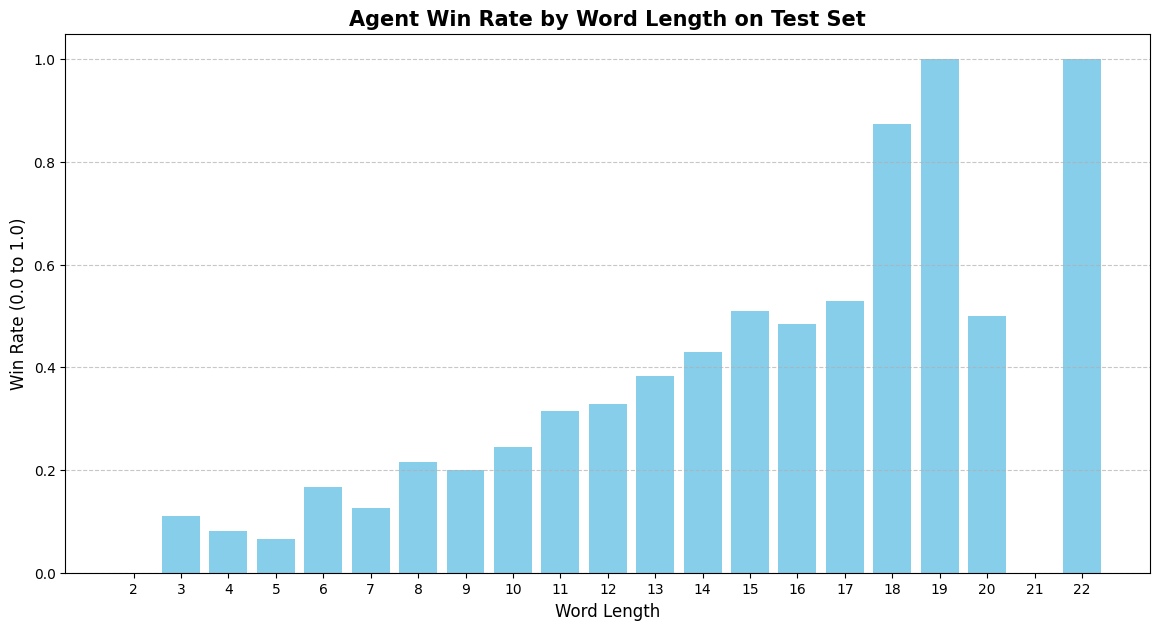

In [ ]:
# Cell 10a: Plot Win Rate by Word Length
import pandas as pd
import matplotlib.pyplot as plt

print("📊 Analyzing win rate by word length...")

# Use a specific try/except to give a better error message
try:
    # 1. Check if 'results' exists and has the required key
    if 'results' not in locals() or 'game_details' not in results:
        print("❌ Error: 'results' variable not found or is missing 'game_details'.")
        print("👉 Please re-run 'Cell 10: Evaluation on Test Set' *one time* to fix this.")
        print("👉 Then, run this cell again.")
    else:
        game_details = results['game_details']
        df = pd.DataFrame(game_details)

        # 2. Calculate the length of each word
        df['word_length'] = df['word'].apply(len)

        # 3. Group by word length and calculate the win rate (mean of 'won' column)
        win_rate_by_length = df.groupby('word_length')['won'].mean().reset_index()

        # 4. Create the bar plot
        plt.figure(figsize=(14, 7))

        # --- FIX ---
        # The DataFrame column with the win rate is named 'won' (from the .mean() operation).
        # We plot 'word_length' vs. the 'won' column (which now holds the win rate).
        # --- --- ---
        plt.bar(win_rate_by_length['word_length'], win_rate_by_length['won'], color='skyblue')

        plt.xlabel('Word Length', fontsize=12)
        plt.ylabel('Win Rate (0.0 to 1.0)', fontsize=12)
        plt.title('Agent Win Rate by Word Length on Test Set', fontsize=15, fontweight='bold')

        # Set x-ticks to be integers starting from the min length
        try:
            min_len = int(win_rate_by_length['word_length'].min())
            max_len = int(win_rate_by_length['word_length'].max())
            plt.xticks(range(min_len, max_len + 1))
        except:
            # Fallback if there's no data
            pass

        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # 5. Save the plot
        plt.savefig('win_rate_by_length.png')
        print("✅ Plot saved to win_rate_by_length.png")

except Exception as e:
    print(f"An unexpected error occurred: {e}")
    print("Please ensure 'results' is in memory by re-running Cell 10.")

In [ ]:
# Cell 11: Download Trained Models and Results
from google.colab import files

print("📥 Downloading models and results...")

# Download trained models
files.download('hmm_model.pkl')
files.download('agent_model.pkl')
files.download('evaluation_results.json')

print("✅ Downloads complete!")


📥 Downloading models and results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloads complete!
